# 回線切れの数
# 武器の詳細追加
#### cv score :  0.5490586011342156 (5 folds)
#### cv score :  0.551296786389414 (10 folds)

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro, NNModel
import warnings

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tensorflow.keras.callbacks import EarlyStopping


random.seed(0)

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/spla/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(132250, 193)
(28340, 192)


### 武器の情報を個人ごとからチームごとに変える
category1, 2を落とす、

他のカテゴリをチームごとにする

reskinそのまま

In [ ]:
# 落とさないほうが精度上がってしまった。。。

"""suffixes = ["-A1", "-A2", "-A3", "-A4", "-B1", "-B2", "-B3", "-B4"]
drop_cols = ["category1", "category2"]

for c in drop_cols:
    for s in suffixes:
        col = c+s
        train_df.drop(col, axis=1, inplace=True)
        test_df.drop(col, axis=1, inplace=True)
"""

In [3]:
y = train_df["y"]
train_df = train_df.drop("y", axis=1)

In [ ]:
# add info about numeric column

num_cols = ["level", "range", "rapid-", "atack"]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

In [ ]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

In [ ]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [ ]:
# categorize team

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df_, test_df_ = prepro.categorize_team(train_df, test_df, col)

In [ ]:
#target encoding

#cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B", 
#                  "team-category2-A", "team-category2-B", "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"]

cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B"]
for col in cat_tgtenc_cols:
    print(col)
    train_df, test_df = prepro.target_encoding(train_df, test_df, y, col, "y")
    

In [4]:
# make input

# categorical_feature = train_df.dtypes[train_df.dtypes == "object"].index.to_list()

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]
X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, verbose=False)

X[categorical_feature] = X[categorical_feature].astype("category")

In [5]:
# 全データを5つに分割
SIZE = X.shape[0]
K = 5

folds = prepro.make_kfolds(SIZE, K)
print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    

    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [7]:
THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices]
    train_y = y.iloc[train_indices]
    valid_X = X.iloc[valid_indices]
    valid_y = y.iloc[valid_indices]
    
    

    train_X = NNModel.prepro_nn(train_X, categorical_feature)
    train_y = train_y.values.reshape(-1, 1)
    valid_X = NNModel.prepro_nn(valid_X, categorical_feature)
    valid_y = valid_y.values.reshape(-1, 1)
    
    
    model = NNModel.make_model(X, categorical_feature)
    cb = EarlyStopping(monitor='val_loss', patience=2)

    model.fit(
        train_X, 
        train_y,
        batch_size=128,
        epochs=2,
        verbose=1,
        callbacks=[cb],
        validation_data=(valid_X, valid_y),
    )
    
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 0 ========================
121
Train on 105800 samples, validate on 26450 samples
Epoch 1/2
105800/105800 [==============================] - 34s 317us/sample - loss: 13.6913 - val_loss: 0.6932
Epoch 2/2
105800/105800 [==============================] - 24s 231us/sample - loss: 0.6937 - val_loss: 0.6933
======================== fold 1 ========================
121
Train on 105800 samples, validate on 26450 samples
Epoch 1/2
105800/105800 [==============================] - 34s 319us/sample - loss: 14.0046 - val_loss: 0.6932
Epoch 2/2
105800/105800 [==============================] - 25s 233us/sample - loss: 0.6935 - val_loss: 0.6933
======================== fold 2 ========================
121
Train on 105800 samples, validate on 26450 samples
Epoch 1/2
105800/105800 [==============================] - 35s 328us/sample - loss: 16.3756 - val_loss: 0.6932
Epoch 2/2
105800/105800 [==============================] - 26s 244us/sample - loss: 0.6941 - val_loss: 0.6933
=

0.49070887272847563
0.5092683500022054
0.5064181245037932
0.48219444689484825
0.5168542833671489
0.5010887259064044


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

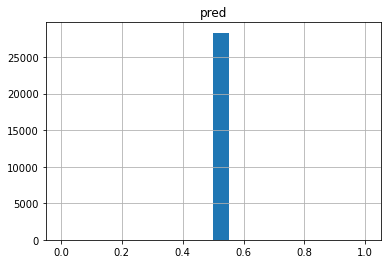

In [30]:
preds = []
#test_X = NNModel.prepro_nn(test_X, categorical_feature)

for i in range(K):
    model = models[i]
    pred = model.predict(test_X, batch_size=128).reshape(-1, )
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":preds})
temp.hist(bins=20)

In [31]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission1_{}.csv'.format(K))

1.0


# モデル解釈

In [ ]:
importance = pd.DataFrame(models[1].feature_importance(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:50])

In [ ]:
importance["importance"].sum()

In [ ]:
train_df["pred"] = 0
train_df["y"] = y.values
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
train_df

In [ ]:
model = NNModel.make_model(X, categorical_feature)

train_data = NNModel.prepro_nn(X, categorical_feature)
model.fit(train_data, y.values.reshape(-1, 1), epochs=2)